In [5]:
import openmeteo_requests
import pandas as pd
import matplotlib.pyplot as plt
import requests_cache
import pandas as pd
from retry_requests import retry
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

url = "https://archive-api.open-meteo.com/v1/archive"




# DEFINE PARAMAS FOR BOTH HYD AND NAGPUR

In [6]:
nagpur_params = {
	"latitude": 21.1463,
	"longitude": 79.0849,
	"start_date": "2023-01-01",
	"end_date": "2023-12-31",
	"daily": ["temperature_2m_max", "rain_sum", "wind_speed_10m_max"]
}

hyderabad_params = {
	"latitude": 17.384,
	"longitude": 78.4564,
	"start_date": "2023-01-01",
	"end_date": "2023-12-31",
	"daily": ["temperature_2m_max", "rain_sum", "wind_speed_10m_max"]
}


# GET DATA FUNCTION

In [7]:

def get_data(responses):
    response = responses[0]
    daily = response.Daily()
    daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
    daily_uv_index_max = daily.Variables(1).ValuesAsNumpy()
    daily_snowfall_sum = daily.Variables(2).ValuesAsNumpy()
    
    daily_data = {"date": pd.date_range(
    	start = pd.to_datetime(daily.Time(), unit = "s"),
    	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
    	freq = pd.Timedelta(seconds = daily.Interval()),
    	inclusive = "left"
    )}
    daily_data["temperature_2m_max"] = daily_temperature_2m_max
    daily_data["uv_index_max"] = daily_uv_index_max
    daily_data["snowfall_sum"] = daily_snowfall_sum
    
    daily_dataframe = pd.DataFrame(data = daily_data)
    return daily_dataframe

# Fetch data from the api and then call the above function to get daily data for the given paramaeters

In [8]:
# Define function to calculate seasonal averages
nagpur_data = get_data(openmeteo.weather_api(url, params=nagpur_params))
hyderabad_data = get_data(openmeteo.weather_api(url, params=hyderabad_params))
# nagpur_data['date'] = pd.to_datetime(nagpur_data['date'], unit='s')
# hyderabad_data['date'] = pd.to_datetime(hyderabad_data['date'], unit='s')
nagpur_data.head()


,date,temperature_2m_max,uv_index_max,snowfall_sum
0,2023-01-01,27.272001,0.0,9.531505
1,2023-01-02,27.172001,0.0,11.384199
2,2023-01-03,27.672001,0.0,9.360001
3,2023-01-04,25.222000,0.1,11.923557
4,2023-01-05,26.372002,0.2,11.841756


In [9]:
nagpur_data.tail()

,date,temperature_2m_max,uv_index_max,snowfall_sum
360,2023-12-27,28.272001,0.0,9.957108
361,2023-12-28,28.122002,0.0,10.538843
362,2023-12-29,28.122002,0.0,9.178235
363,2023-12-30,27.922001,0.0,9.904906
364,2023-12-31,28.122002,0.0,11.119281


In [10]:
hyderabad_data.head()

,date,temperature_2m_max,uv_index_max,snowfall_sum
0,2023-01-01,30.205999,0.0,9.114471
1,2023-01-02,29.506001,0.0,10.739833
2,2023-01-03,28.756001,0.0,8.435069
3,2023-01-04,28.756001,0.0,11.480557
4,2023-01-05,26.955999,1.0,12.522619


# Checking if any values are null from the fetched data

In [11]:
nagpur_data.isna().all()

date                  False
temperature_2m_max    False
uv_index_max          False
snowfall_sum          False
dtype: bool

In [12]:
hyderabad_data.isna().all()

date                  False
temperature_2m_max    False
uv_index_max          False
snowfall_sum          False
dtype: bool

# FUNCTION TO CALCULATE SEASONAL AVERAGES

In [13]:

def calculate_seasonal_averages(data):
    # Convert the response data to a DataFrame
    df = pd.DataFrame(data)

    # Convert timestamp to datetime format
    df['date'] = pd.to_datetime(df['date'], unit='s')

    # Extract month from the timestamp
    df['month'] = df['date'].dt.month

    # Define seasons
    seasons = {
        1: 'Spring',
        2: 'Spring',
        3: 'Spring',
        4: 'Summer',
        5: 'Summer',
        6: 'Summer',
        7: 'Rainy',
        8: 'Rainy',
        9: 'Rainy',
        10: 'Winter',
        11: 'Winter',
        12: 'Winter',
    }

    # Map months to seasons
    df['season'] = df['month'].map(seasons)

    # Group by season and calculate averages
    seasonal_averages = df.groupby('season').mean()

    return seasonal_averages

# PRINTING SEASONAL AVERAGES

In [14]:


# Calculate seasonal averages for each city
print(calculate_seasonal_averages(nagpur_data))



                      date  temperature_2m_max  uv_index_max  snowfall_sum  \
season                                                                       
Rainy  2023-08-15 12:00:00           30.967110     11.657609     15.296933   
Spring 2023-02-14 12:00:00           31.552002      0.354444     12.769542   
Summer 2023-05-16 00:00:00           37.840683      2.793407     18.257811   
Winter 2023-11-15 12:00:00           30.160589      0.354348     11.343659   

           month  
season            
Rainy    7.98913  
Spring   2.00000  
Summer   5.00000  
Winter  11.00000  


In [15]:
print(calculate_seasonal_averages(hyderabad_data))

                      date  temperature_2m_max  uv_index_max  snowfall_sum  \
season                                                                       
Rainy  2023-08-15 12:00:00           29.801651      6.329348     21.068270   
Spring 2023-02-14 12:00:00           31.272112      0.656667     12.331764   
Summer 2023-05-16 00:00:00           35.047207      2.558242     17.522032   
Winter 2023-11-15 12:00:00           29.723391      1.030435     12.955200   

           month  
season            
Rainy    7.98913  
Spring   2.00000  
Summer   5.00000  
Winter  11.00000  


# CALCULATE AND PRINT ANNUAL AVERAGES FOR HYD AND NGP

In [16]:
# Calculate annual averages for each city
nagpur_annual_avg = nagpur_data.mean()
hyderabad_annual_avg = hyderabad_data.mean()


In [17]:
print(nagpur_annual_avg)


date                  2023-07-02 00:00:00
temperature_2m_max              32.621731
uv_index_max                     3.811507
snowfall_sum                    14.415491
dtype: object


In [18]:
print(hyderabad_annual_avg)

date                  2023-07-02 00:00:00
temperature_2m_max              31.452301
uv_index_max                     2.654794
snowfall_sum                    15.984994
dtype: object


# Calculate and tabulate the results of differences in weather parameters between Nagpur and Hyderabad.

In [19]:

differences = hyderabad_data[['temperature_2m_max',	'uv_index_max',	'snowfall_sum']] - nagpur_data[['temperature_2m_max', 'uv_index_max',	'snowfall_sum']]

diff = pd.DataFrame(differences)
diff.head()


,temperature_2m_max,uv_index_max,snowfall_sum
0,2.933998,0.0,-0.417033
1,2.334000,0.0,-0.644366
2,1.084000,0.0,-0.924932
3,3.534000,-0.1,-0.443000
4,0.583998,0.8,0.680863


In [20]:

# Tabulate the differences
table = tabulate(differences, headers='keys', tablefmt='psql')

# Print the tabulated differences
print(table)



+-----+----------------------+----------------+----------------+
|     |   temperature_2m_max |   uv_index_max |   snowfall_sum |
|-----+----------------------+----------------+----------------|
|   0 |            2.934     |       0        |     -0.417033  |
|   1 |            2.334     |       0        |     -0.644366  |
|   2 |            1.084     |       0        |     -0.924932  |
|   3 |            3.534     |      -0.1      |     -0.443     |
|   4 |            0.583998  |       0.8      |      0.680863  |
|   5 |            0.883999  |       0.2      |      0.636772  |
|   6 |            1.834     |       0        |      2.99998   |
|   7 |            0.133999  |       0        |      1.64036   |
|   8 |            0.0339985 |       0        |      1.9573    |
|   9 |            0.0339985 |       0        |     -0.504272  |
|  10 |            0.334     |       0        |      0.842892  |
|  11 |            0.684     |       0        |     -0.309275  |
|  12 |            0.1339

# Plot time-series “daily” values of weather parameters of Hyd and Nagpur

In [21]:


def plot_daily_weather(data, city , parameter):
    
    data.index = pd.to_datetime(data["date"])
    
    # Plot data
    plt.figure(figsize=(15, 7))
    plt.plot(data.index, data[parameter], label=f'{city} {parameter}', color='green')
   
    plt.xlabel('Date')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.ylabel('Values')
    plt.title(f'Daily {parameter} for {city}')
    
    plt.legend()
    plt.grid(True)
    
    plt.show()



NameError: name 'mdates' is not defined

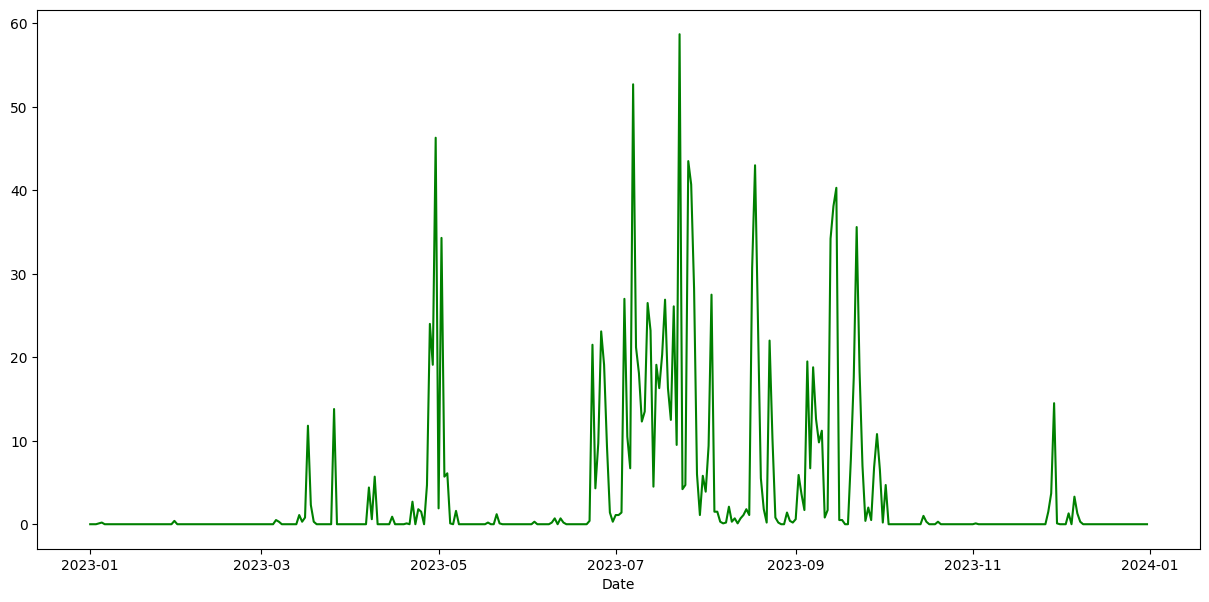

In [22]:

# Usage example:
plot_daily_weather(nagpur_data, 'Nagpur', 'uv_index_max')

# plot_daily_weather(hyderabad_data, 'Hyderabad')

In [ ]:
plot_daily_weather(nagpur_data, 'Nagpur', 'temperature_2m_max')


In [ ]:
plot_daily_weather(nagpur_data, 'Nagpur', 'snowfall_sum')

In [ ]:
plot_daily_weather(hyderabad_data, 'HYD', 'snowfall_sum')

In [ ]:
plot_daily_weather(hyderabad_data, 'HYD', 'temperature_2m_max')


In [ ]:
plot_daily_weather(nagpur_data, 'HYD', 'uv_index_max')


# A simple linear regression model for predicting the next day weather parameter.

In [23]:
def build_linear_regression_model(data, feature, historical_data_length ):
    # Remove rows with missing values
    data.dropna(inplace=True)

    # Prepare the data
    X = data[feature].values.reshape(-1, 1)
    y = data[feature].shift(-1).values  # Target variable is the temperature for the next day

    
    # Drop NaN values from y
    
    nan_indices = np.isnan(y)
    X = X[~nan_indices]
    y = y[~nan_indices]

    # Use only the specified length of historical data
    X = X[-historical_data_length:]
    y = y[-historical_data_length:]


    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    #mse = mean_squared_error(y_test, y_pred)
    #print(f'Mean Squared Error: {mse}')

    # Make predictions for the next day's weather parameters
    next_day_temperature = data[feature].tail(1).values.reshape(-1, 1)
    next_day_prediction = model.predict(next_day_temperature)
    # print(f'Next day {feature} prediction for given city:', next_day_prediction)
    return next_day_prediction

In [24]:

result = build_linear_regression_model(nagpur_data,'temperature_2m_max', 365)
print("Next day temperature_2m_max prediction for given city:", result)
result = build_linear_regression_model(nagpur_data,'uv_index_max', 365)
print("Next day uv_index_max prediction for given city:", result)
result =build_linear_regression_model(nagpur_data,'snowfall_sum', 365)
print("Next day snowfall_sum prediction for given city:", result)

Next day temperature_2m_max prediction for given city: [28.488052]
Next day uv_index_max prediction for given city: [1.6037385]
Next day snowfall_sum prediction for given city: [12.235569]


In [25]:
result = build_linear_regression_model(hyderabad_data,'temperature_2m_max', 365)
print("Next day temperature_2m_max prediction for given city:", result)
result = build_linear_regression_model(hyderabad_data,'uv_index_max', 365)
print("Next day uv_index_max prediction for given city:", result)
result =build_linear_regression_model(hyderabad_data,'snowfall_sum', 365)
print("Next day snowfall_sum prediction for given city:", result)


Next day temperature_2m_max prediction for given city: [28.206312]
Next day uv_index_max prediction for given city: [1.3462294]
Next day snowfall_sum prediction for given city: [11.139416]


# Compare different lengths of historical data and see if the prediction changes

In [26]:

def compare_lengths(historical_data_lengths, feature):
# Lists to store predictions for different lengths
    nagpur_predictions = []
    hyderabad_predictions = []
    
    # Call the function for different lengths and store the predictions
    for length in historical_data_lengths:
        nagpur_prediction = build_linear_regression_model(nagpur_data,feature, length)
        hyderabad_prediction = build_linear_regression_model(hyderabad_data,feature, length)
        nagpur_predictions.append(nagpur_prediction)
        hyderabad_predictions.append(hyderabad_prediction)
    
    # Print or visualize the predictions
    print("Nagpur Predictions:", nagpur_predictions)
    print("Hyderabad Predictions:", hyderabad_predictions)

    plt.figure(figsize=(10, 6))
    plt.plot(historical_data_lengths, nagpur_predictions, marker='o', label='Nagpur')
    plt.plot(historical_data_lengths, hyderabad_predictions, marker='o', label='Hyderabad')
    plt.xlabel('Length of Historical Data')
    plt.ylabel(f'{feature} Prediction')
    plt.xticks(historical_data_lengths)
    plt.title(f'Effect of Historical Data Length on {feature} Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

In [27]:
# Define different lengths of historical data

historical_data_lengths = [30, 60, 90, 120, 150,180]

Nagpur Predictions: [array([27.94785], dtype=float32), array([28.213682], dtype=float32), array([28.17874], dtype=float32), array([28.357058], dtype=float32), array([28.468603], dtype=float32), array([28.486212], dtype=float32)]
Hyderabad Predictions: [array([28.015608], dtype=float32), array([28.274673], dtype=float32), array([28.190447], dtype=float32), array([28.269659], dtype=float32), array([28.390675], dtype=float32), array([28.460932], dtype=float32)]


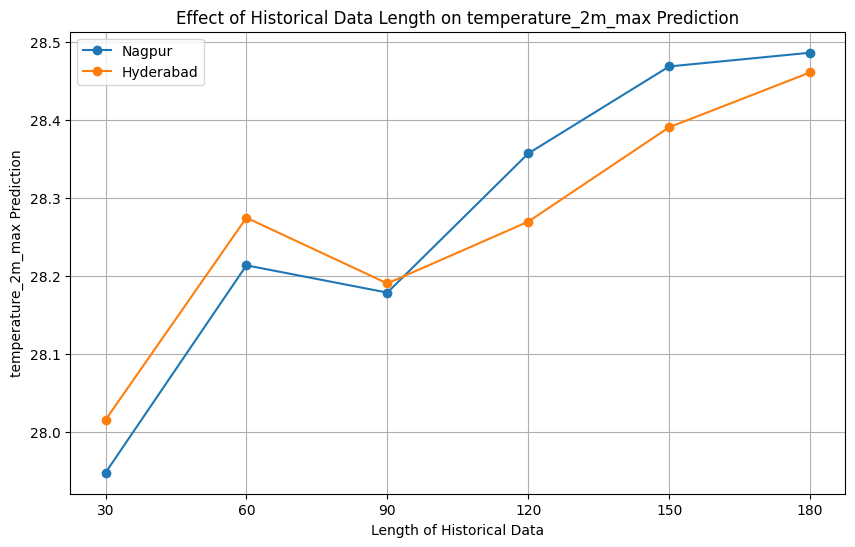

In [28]:
compare_lengths(historical_data_lengths, 'temperature_2m_max')

Nagpur Predictions: [array([0.1960026], dtype=float32), array([0.42183584], dtype=float32), array([0.21045712], dtype=float32), array([0.7273109], dtype=float32), array([1.2357266], dtype=float32), array([2.3904376], dtype=float32)]
Hyderabad Predictions: [array([0.32200155], dtype=float32), array([0.835345], dtype=float32), array([1.0515015], dtype=float32), array([1.2973763], dtype=float32), array([1.2310429], dtype=float32), array([1.5078256], dtype=float32)]


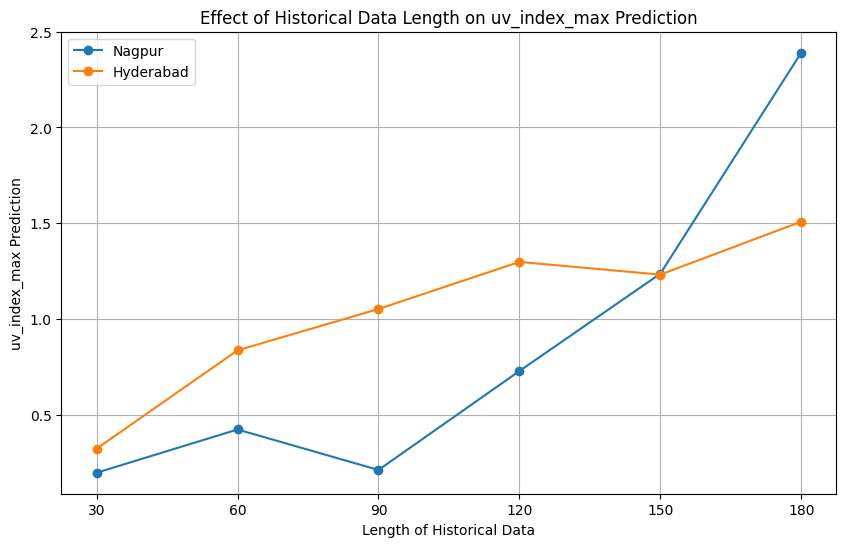

In [29]:
compare_lengths(historical_data_lengths, 'uv_index_max')

Nagpur Predictions: [array([11.399434], dtype=float32), array([10.89101], dtype=float32), array([11.202732], dtype=float32), array([11.589342], dtype=float32), array([11.80813], dtype=float32), array([11.905766], dtype=float32)]
Hyderabad Predictions: [array([10.406777], dtype=float32), array([10.866677], dtype=float32), array([11.2590685], dtype=float32), array([10.763647], dtype=float32), array([10.845304], dtype=float32), array([10.450761], dtype=float32)]


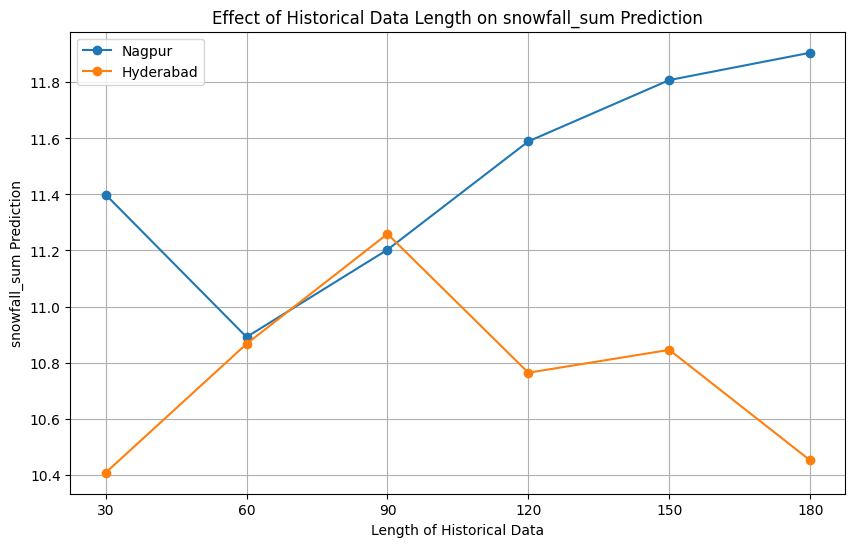

In [30]:
compare_lengths(historical_data_lengths, 'snowfall_sum')